In [17]:
#Importing the Libraries
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
import math as math
from arch.unitroot import *

from statsmodels.tsa.stattools import adfuller, kpss
from numpy import log

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [18]:
#Get the Dataset
df=pd.read_csv('./data/Stock_Price_BRL 2016-2021.csv',index_col='Date',parse_dates=True,infer_datetime_format=True)
df.head()

,Close_Stock(EUR),Close_EUR,Close_Stock(BRL)
Date,,,
2016-01-04,70.580002,4.2891,302.724687
2016-01-05,71.430000,4.3710,312.220530
2016-01-06,72.050003,4.3301,311.983718
2016-01-07,71.339996,4.3322,309.059131
2016-01-08,71.050003,4.4145,313.650238


In [19]:
df_2020 = pd.DataFrame(df['2020'])

df_2020.pop("Close_Stock(EUR)")
df_2020.pop("Close_EUR")

df_2020.to_csv('./data/Stock_Price_BRL_2020.csv')

C:\Users\I514609\AppData\Local\Temp/ipykernel_31848/1696594534.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df_2020 = pd.DataFrame(df['2020'])


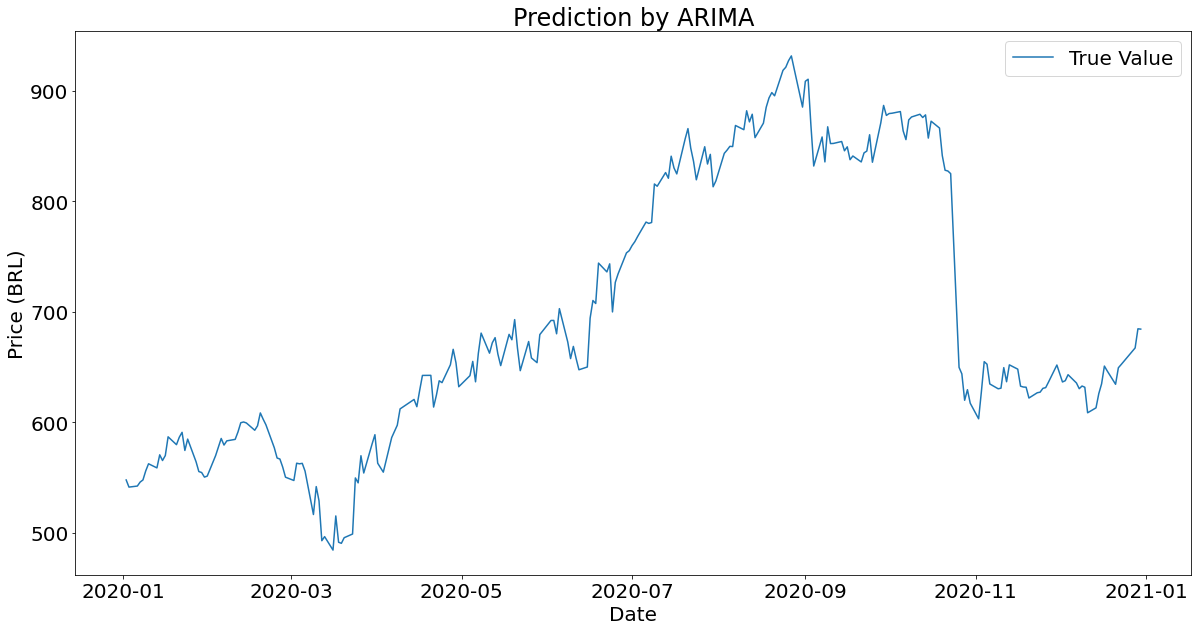

In [20]:
plt.figure(figsize = (20,10))
plt.plot(df_2020['Close_Stock(BRL)'], label='True Value')
plt.title("Prediction by ARIMA")
plt.xlabel('Date')
plt.ylabel('Price (BRL)')
plt.legend()
plt.savefig('./images/LSTM_Prediction.png')
plt.show()

In [26]:
# Check if the time series is stationary (This time series is not stationary)
#Augmented Dickey-Fuller Test
#Augmented Dickey-Fuller Test
X = df_2020['Close_Stock(BRL)'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.481048
p-value: 0.542865
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


In [24]:
#Test KPSS
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

In [25]:
#KPSS Test
kpss_test(df_2020['Close_Stock(BRL)'].values)

KPSS Statistic: 1.1020435300041573
p-value: 0.01
num lags: 10
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [23]:
php_ct = PhillipsPerron(df_2020['Close_Stock(BRL)'])
php_ct.summary()

Test Statistic,-1.591
P-value,0.488
Lags,16


In [7]:
#result_adf = adfuller(df_2020.diff().dropna())
#result_adf

kpss(df_2020.diff().dropna())


c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.19218236952128495,
 0.1,
 0,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [8]:
## Adf Test
print(ndiffs(df_2020, test='adf'))  # 1

# KPSS test
print(ndiffs(df_2020, test='kpss'))  # 1

# PP test:
print(ndiffs(df_2020, test='pp'))  # 1

1
1
1


In [9]:
# First Differential
df_202_diff = df_2020.diff().dropna()

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


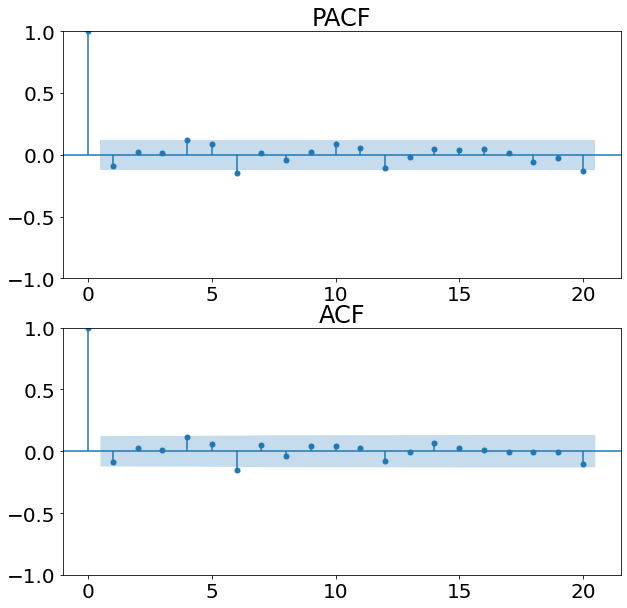

In [16]:
# First Differential
# Partial Autocorrelation = 1
plt.rcParams['font.size'] = '20'
fig, ax = plt.subplots(2,1,figsize=(10,10))
plot_pacf(df_202_diff, lags=20,ax=ax[0], title="PACF")
plot_acf(df_202_diff, lags=20,ax=ax[1], title="ACF")
plt.savefig('./images/PACF_ACF.png')
plt.show()



In [172]:
pm.auto_arima(df_2020, information_criterion='aic',stationary=False, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2212.297, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2212.347, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2212.445, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2210.501, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2214.215, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.662 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [179]:
arima_model = ARIMA(df_2020,order=(0,1,0)).fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [207]:
df_2020["predicted"] = arima_model.predict()
df_2020

,Close_Stock(BRL),predcited,predicted
Date,,,
2020-01-02,547.572600,0.000000,0.000000
2020-01-03,541.106316,547.572600,547.572600
2020-01-06,542.061119,541.106316,541.106316
2020-01-07,545.662331,542.061119,542.061119
2020-01-08,547.580404,545.662331,545.662331
...,...,...,...
2020-12-22,649.106785,634.165578,634.165578
2020-12-23,652.017477,649.106785,649.106785
2020-12-28,667.053685,652.017477,652.017477


In [209]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [210]:
mse = mean_squared_error(df_2020['Close_Stock(BRL)'], df_2020['predicted'])
rmse = math.sqrt(mse)
mape = mean_absolute_percentage_error(df_2020['Close_Stock(BRL)'], df_2020['predicted'])
r2 = r2_score(df_2020['Close_Stock(BRL)'], df_2020['predicted'])


print(mse)
print(rmse)
print(mape)
print(r2)

1540.9331204528391
39.254720995732974
2.225059495052383
0.8967287431589548
